In [2]:
from __future__ import print_function
import time
import boto3
import json
from sagemaker import get_execution_role

REGION = 'us-west-2'
BUCKET = 'jashuang-sagemaker-5-22'
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

ROLE = get_execution_role()
display(ROLE)
# need to attach policies

'arn:aws:iam::688520471316:role/service-role/AmazonSageMaker-ExecutionRole-20200522T134110'

In [43]:
## ComprehendFullAccess 
## AmazonSageMakerFullAccess 
## AmazonS3FullAccess 
## AmazonAugmentedAIFullAccess

In [3]:
transcribe = boto3.client('transcribe', REGION)
s3 = boto3.client("s3", REGION)
job_name_1 = "AWS-sage-1"
# audio file path
job_uri_1 = "https://jashuang-sagemaker-5-22.s3-us-west-2.amazonaws.com/transcribe-bucket/Fully-Managed+Notebook+Instances+with+Amazon+SageMaker+-+a+Deep+Dive.mp4"
job_uri_s3 = "s3://jashuang-sagemaker-5-22/transcribe-bucket/Fully-Managed Notebook Instances with Amazon SageMaker - a Deep Dive.mp4"
out_bucket = "jashuang-sagemaker-5-22"

In [5]:
# transcribe.start_transcription_job(
#     TranscriptionJobName=job_name,
#     Media={'MediaFileUri': job_uri},
#     MediaFormat='mp4',
#     LanguageCode='en-US'
# )

In [67]:
def transcribe(job_name, job_uri, out_bucket, format="mp4", vocab_name=None):
    """Transcribe a .wav or .mp4 file to text.
    Args:
        job_name (str): the name of the job that you specify;
                        the output json will be job_name.json
        job_uri (str): input path (in s3) to the file being transcribed
        out_bucket (str): s3 bucket name that you want the output json
                          to be placed in
        format (str): mp4 or wav for input file format;
                      defaults to mp4
        vocab_name (str): 
    """
    
    if format not in ['mp3','mp4','wav','flac']:
        print("Invalid format")
        return

    try:
        transcribe = boto3.client("transcribe")
        print("------" + format)
        transcribe.start_transcription_job(
            TranscriptionJobName=job_name,
            Media={"MediaFileUri": job_uri},
            MediaFormat=format,
            LanguageCode="en-US",
            OutputBucketName=out_bucket,
            Settings={'VocabularyName': vocab_name}
        )
        
        while True:
            status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(5)
        print(status)

    except Exception as e:
        print(e)

In [75]:
def get_transcript_text_and_timestamps(bucket_name, file_name):
    """take json file from s3 bucket and returns a tuple of:
       entire transcript, list object of tuples of timestamp and individual sentences
    
    Args:
        bucket_name (str): name of s3 bucket
        file_name (str): name of file
    Returns:
        (entire_transcript: str,
        [ {timestamp (in seconds) : int, sentence : str} ])
    """
    s3_clientobj = s3.get_object(Bucket=bucket_name, Key=file_name)
    s3_clientdata = s3_clientobj["Body"].read().decode("utf-8")

    original = json.loads(s3_clientdata)
    items = original["results"]["items"]
    entire_transcript = original["results"]["transcripts"]

    sentences_and_times = []
    temp_sentence = ""
    temp_start_time = 0
    temp_min_confidence = 1.0
    newSentence = True
    
    confidences = []
    scores = []

    i = 0
    for item in items:
        # always add the word
        if item["type"] == "punctuation":
            temp_sentence = (
                temp_sentence.strip() + item["alternatives"][0]["content"] + " "
            )
        else:
            temp_sentence = temp_sentence + item["alternatives"][0]["content"] + " "
            temp_min_confidence = min(temp_min_confidence,
                                      float(item["alternatives"][0]["confidence"]))
            confidences.append({"start_time": float(item["start_time"]),
                                "end_time": float(item["end_time"]),
                                "content": item["alternatives"][0]["content"],
                                "confidence": float(item["alternatives"][0]["confidence"])
                               })
            scores.append(float(item["alternatives"][0]["confidence"]))

        # if this is a new sentence, and it starts with a word, save the time
        if newSentence == True:
            if item["type"] == "pronunciation":
                temp_start_time = float(item["start_time"])
            newSentence = False
        # else, keep going until you hit a punctuation
        else:
            if (
                item["type"] == "punctuation"
                and item["alternatives"][0]["content"] != ","
            ):
                # end time of sentence is end_time of previous word
                end_time = items[i-1]["end_time"] if i-1 >= 0 else items[0]["end_time"]
                sentences_and_times.append(
                    {"start_time": temp_start_time,
                     "end_time": end_time,
                     "sentence": temp_sentence.strip(),
                     "min_confidence": temp_min_confidence
                    }
                )
                # reset the temp sentence and relevant variables
                newSentence = True
                temp_sentence = ""
                temp_min_confidence = 1.0
                
        i = i + 1

    return entire_transcript, sentences_and_times, confidences, scores

In [84]:
# transcribe(job_name_1, job_uri_1, out_bucket)

In [81]:
entire_transcript_1, sentences_and_times_1, confidences_1, scores = get_transcript_text_and_timestamps("jashuang-sagemaker-5-22","AWS-sage-1.json")

In [86]:
print(sentences_and_times_1[0])

{'start_time': 0.54, 'end_time': '1.03', 'sentence': 'Hi.', 'min_confidence': 1.0}


In [88]:
file0 = open("originaltranscript.txt","w") 
for tup in sentences_and_times_1:
    file0.write(tup['sentence'] + "\n") 
file0.close()

In [12]:
# entire_transcript_1

In [19]:
# print(scores)

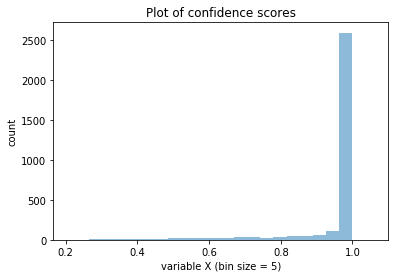

In [94]:
from matplotlib import pyplot as plt

plt.xlim([min(scores)-0.1, max(scores)+0.1])
plt.hist(scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [41]:
import numpy as np
print(len(scores))

3174


In [35]:
bad_scores = [i for i in scores if i < 0.9]

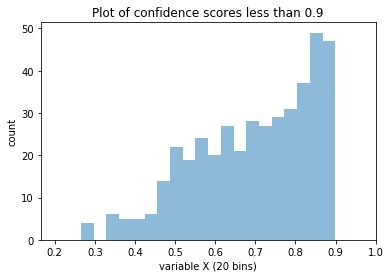

In [39]:
plt.xlim([min(bad_scores)-0.1, 1.0])
plt.hist(bad_scores, bins=20, alpha=0.5)
plt.title('Plot of confidence scores less than 0.9')
plt.xlabel('variable X (20 bins)')
plt.ylabel('count')

plt.show()

In [40]:
len(bad_scores)

421

In [106]:
# for tup in sentences_and_times_1:
#     print(str(tup['start_time']) + " -- "  +
#           str(tup['end_time']) + " -- "+
#           tup['sentence']+ " -- "+
#           str(tup['min_confidence'])
#          )

In [96]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-west-2:688520471316:workteam/private-crowd/jashuang-test-workforce"

In [34]:
import io
import json
import uuid
import time
import boto3
import botocore

# Amazon SageMaker client
sagemaker = boto3.client('sagemaker', REGION)

# Amazon Comprehend client
comprehend = boto3.client('comprehend', REGION)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

s3 = boto3.client('s3', REGION)

In [153]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
    <video controls>
        <source src="{{ task.input.audioPath | grant_read_access }}#t={{ task.input.start_time }},{{ task.input.end_time }}"
            type="audio/mp4">
        Your browser does not support the audio element.
    </video>
    <p>If you need to replay the audio, please refresh the page.</p>

    <h3>Instructions</h3>
    <p>Transcribe the audio </p>
    <p>Ignore "umms", "hmms", "uhs" and other non-textual phrases. </p>
    <p>The original transcript is <strong>"{{ task.input.original_words }}"</strong>. If the text matches the audio, please retype the same transcription.</p>
    <p>Click the space below to start typing.</p>
    <crowd-text-area name="transcription" rows="2"></crowd-text-area>

    <full-instructions header="Transcription Instructions">
        <h2>Instructions</h2>
        <p>Click the play button once and listen carefully to the audio section clip. Type what you hear in the box
            below.</p>
    </full-instructions>

</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [154]:
# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-transcribe-' + str(uuid.uuid4()) 

# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-west-2:688520471316:human-task-ui/ui-transcribe-34c3252c-b50e-41c0-8d6f-47dba65f5db0


In [155]:
# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-transcribe-demo-' + str(uuid.uuid4()) 

create_workflow_definition_response = sagemaker.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify the word(s) spoken in the provided audio clip",
            "TaskTitle": "Determine Words/Phrases of Audio Clip"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [156]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


In [82]:
print(confidences_1[0:1])

[{'start_time': 0.54, 'end_time': 1.03, 'content': 'Hi', 'confidence': 1.0}]


In [157]:
# use this to get the words near a word with poor confidence,
# since it is possible that the transcription also mis-transcribed nearby words/phrases
def get_word_neighbors(words, index):
    """
    gets the words transcribe found at most 3 away from the input index
    Returns:
    list: words at most 3 away from the input index
    int: starting time of the first word in the list
    int: ending time of the last word in the list
    """
    i = max(0, index - 3)
    j = min(len(words) - 1, index + 3)
    return words[i: j + 1], words[i]["start_time"], words[j]["end_time"]

In [137]:
words_list, start, end = get_word_neighbors(confidences_1, 5)
print(words_list)
print(len(words_list))
print(start)
print(end) #hello

[{'start_time': 1.5, 'end_time': 1.7, 'content': 'name', 'confidence': 1.0}, {'start_time': 1.7, 'end_time': 1.85, 'content': 'is', 'confidence': 1.0}, {'start_time': 1.85, 'end_time': 2.1, 'content': 'Emily', 'confidence': 0.9886}, {'start_time': 2.1, 'end_time': 2.51, 'content': 'Weber', 'confidence': 0.7289}, {'start_time': 2.74, 'end_time': 2.97, 'content': "I'm", 'confidence': 0.9645}, {'start_time': 2.97, 'end_time': 3.11, 'content': 'a', 'confidence': 1.0}, {'start_time': 3.11, 'end_time': 3.43, 'content': 'machine', 'confidence': 1.0}]
7
1.5
3.43


In [138]:
sequence = ""
for block in words_list:
    sequence += block['content'] + " "
print(sequence)

name is Emily Weber I'm a machine 


In [62]:
# bad_conf_words = []
# i=0
# for obj in confidences_1:
#     if obj['confidence'] < 0.4:
#         bad_conf_words.append(obj)
#     i=i+1

In [68]:
# print(bad_conf_words[2])

{'start_time': 91.02, 'end_time': 91.36, 'content': 'Annecy', 'confidence': 0.3542}


In [158]:
# Sample data, human loop started
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .4
i = 0
for obj in confidences_1:
    word = obj["content"]
    neighbors, start_time, end_time = get_word_neighbors(confidences_1, i)
    
#     print(f'Processing word: \"{obj["content"]}\"')
    
    # Our condition for when we want to engage a human for review
    if (obj["confidence"] < CONFIDENCE_SCORE_THRESHOLD):
        
        # get the original sequence of words
        sequence = ""
        for block in neighbors:
            sequence += block['content'] + " "
        
        humanLoopName = str(uuid.uuid4())
        # "initialValue": word,
        inputContent = {
            "audioPath": job_uri_s3,
            "start_time": start_time,
            "end_time": end_time,
            "original_words": sequence
        }
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'Confidence score of {obj["confidence"]} is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}')
        print(f'Starting human loop with name: {humanLoopName}')
        print(f'Sending words from times {start_time} to {end_time} to review')
        print(f'The original transcription is ""{sequence}"" \n')
#     else:
# #         print(f'SentimentScore of {obj["confidence"]} is above threshold of {CONFIDENCE_SCORE_THRESHOLD}')
# #         print('No human loop created. \n')

    i=i+1

Confidence score of 0.3945 is less than the threshold of 0.4
Starting human loop with name: 6228b6ee-0a2e-4376-954a-065044664e71
Sending words from times 44.2 to 46.37 to review
The original transcription is ""show up Under are easy to console "" 

Confidence score of 0.3907 is less than the threshold of 0.4
Starting human loop with name: f4117366-8aeb-4c33-b7c6-2d1620a471c5
Sending words from times 69.11 to 72.08 to review
The original transcription is ""And more cores see is compute optimized "" 

Confidence score of 0.3542 is less than the threshold of 0.4
Starting human loop with name: 92116669-2e55-44a3-b738-303a566494cc
Sending words from times 89.94 to 92.93 to review
The original transcription is ""every version of Annecy two instance is "" 

Confidence score of 0.3372 is less than the threshold of 0.4
Starting human loop with name: 87dd39a8-3b4b-4137-8962-db517846223b
Sending words from times 338.43 to 340.78 to review
The original transcription is ""distributing data sets wan

In [32]:
# Check Status of Human Loop

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



NameError: name 'human_loops_started' is not defined

In [109]:
# Wait For Workers to Complete Task
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://v3t960yxw8.labeling.us-west-2.sagemaker.aws


In [35]:
# Check Status of Human Loop Again

# if you restart the notebook, use this temp list of completed human loops


human_loops_started=['ce67adb4-84c3-4d00-a29a-1a2324570677',
                         '20f0e6be-95f7-4d17-a538-2e0ad26df99f',
                         '99f18c81-9ce8-4d0c-9527-e5e52b076d9c',
                         '7283c5b2-97dd-42d5-8d63-f728fb2e3a52',
                         'f659d1b7-c296-48bd-be9e-d7862907a312',
                         '4a7b4def-0dae-4d5f-922c-6da6536eb069',
                         '4fdc8d5a-dc8f-4132-ba79-74c5f05f2afc',
                         '63ff3d47-941f-4bd4-bb28-eff4deb2f26c',
                         '59e26a8a-8077-4751-85df-7ee5ce88c8ae',
                         'a8b2c8a5-07b3-4a3f-b5c9-90877519c264'
                        ]

completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)



HumanLoop Name: ce67adb4-84c3-4d00-a29a-1a2324570677
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/18/ce67adb4-84c3-4d00-a29a-1a2324570677/output.json'}


HumanLoop Name: 20f0e6be-95f7-4d17-a538-2e0ad26df99f
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/18/20f0e6be-95f7-4d17-a538-2e0ad26df99f/output.json'}


HumanLoop Name: 99f18c81-9ce8-4d0c-9527-e5e52b076d9c
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://jashuang-sagemaker-5-22/a2i-results/fd-transcribe-demo-dda504eb-2b7e-4367-b05b-239d9be0cb95/2020/05/28/23/50/17/99f18c81-9ce8-4d0c-9527-e5e52b076d9c/output.json'}


HumanLoop Name: 7283c5b2-97dd-42d5-8d63-f728fb2e3a52
HumanLoop Status: Completed
HumanLoop Output Destinat

In [7]:

# View Task Results¶

# Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.


import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')



NameError: name 'completed_human_loops' is not defined

In [37]:
corrected_words = []

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    
    # add the human-reviewed answers split by spaces
    corrected_words += json_output['humanAnswers'][0]['answerContent']['transcription'].split(" ")

In [38]:
print(corrected_words)

['then', 'edit', 'your', 'ec2', 'instance', 'or', 'the', 'but', 'definitely', 'use', 'Lambda', 'to', 'turn', 'your', 'right', 'up', 'here', 'then', 'the', 'title', 'of', 'this', 'is', 'from', 'Sarab', "he's", 'the', 'author', 'the', 'internet', 'so', 'this', 'is', 'from', 'the', 'python', 'SDK', "we're", 'getting', 'our', "that's", 'that', 'python', 'SDK', "we're", 'getting', 'absolutely', 'upgrade', 'and', 'its', 'fun', 'because', 'you', 'I', 'started', 'using', 'boto3', 'but', 'I', 'the', 'two', 'main', 'ones', 'markdown', 'is', 'gonna']


In [21]:
# pip3 install pyenchant
# Do "yum install enchant" as root
!pip3 install autocorrect

    100% |████████████████████████████████| 1.8MB 11.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for autocorrect ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/78/7f/b1/527522820ae623df6a2dbe14f778d23adaea4bebe43f7ebcfe
Successfully built autocorrect
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
# import enchant

In [18]:
# print(enchant.list_languages())

[]


In [46]:
# from autocorrect import Speller

# spell = Speller(lang='en')

TypeError: __init__() missing 1 required positional argument: 'word'

In [52]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [53]:
from nltk.corpus import words

In [54]:
my_dict=set(words.words()) 

In [66]:
'Lambda' in my_dict

False

False

In [70]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text)
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab - english_vocab
    return sorted(unusual)

In [73]:
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
def remove_contractions(word_list):
    return [word for word in word_list if word not in contractions]

In [74]:
print(unusual_words(corrected_words))

['boto3', 'ec2', 'gonna', "he's", 'internet', 'ones', 'sarab', 'sdk', 'started', "that's", 'using', "we're"]


In [75]:
print(remove_contractions(unusual_words(corrected_words)))

['boto3', 'ec2', 'gonna', 'internet', 'ones', 'sarab', 'sdk', 'started', 'using']


In [64]:
for word in corrected_words:
    if word not in my_dict:
        print(word)

ec2
Lambda
Sarab
he's
internet
SDK
we're
that's
SDK
we're
started
using
boto3
ones
gonna


In [54]:
finalized_words=[['Phrase','IPA','SoundsLike','DisplayAs'],
                 ['E.C.-Two','','ee-see-too','EC2'],
                 ['E.C.-Two-instance','','ee-see-too-in-stunce','EC2 instance'],
                 ['lambda','','lam-duh','lambda'],
                 ['S.D.K.','','ess-dee-kay','SDK'],
                 ['boto-three','','boe-toe-three','Boto3'],
                 ['S.-Three','','ess-three','S3'],
                 ['github','','git-hub','Github'],
                 ['sagemaker','','sage-may-ker','SageMaker'],
                 ['E.B.S.','','ee-bee-ess','EBS'],
                 ['G.P.U.','','gee-pee-you','GPU'],
                 ['git-repository','','ee-see-too','Git repository'],
                 ['jupyter','','joo-pih-ter','Jupyter'],
                 ['kernel','','ker-null','kernel'],
                 ['config','','con-fig','config'],
                 ['configs','','con-figs','configs'],
                 ['D.B.-pedia','','dee-bee-pee-dee-uh','dbpedia'],
                ]
# finalized_words = [(word + '\n') for word in finalized_words]

In [80]:
print(finalized_words)

['ec2\n', 'lambda\n', 'SDK\n', 'boto3\n']


In [55]:
file1 = open("customvocab.txt","w")
template = '{}\t{}\t{}\t{}\n'
for line in finalized_words:
    file1.write(template.format(line[0],
                                line[1],
                                line[2],
                                line[3])
               )
file1.close()

In [23]:
test2_words=['hello\n','there\n','general\n','kenobi\n']
test2_words_no_newlines=['hello','there','general','kenobi']

In [12]:
file2 = open("test2.txt","w") 
file2.writelines(test2_words) 
file2.close()

In [56]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [57]:
upload_file('customvocab2.txt', BUCKET)

True

In [14]:
upload_file('test2.txt', BUCKET)

True

In [25]:
# # create our custom vocabulary
# transcribe = boto3.client("transcribe")
# response = transcribe.create_vocabulary(
#     VocabularyName='testvocab3',
#     LanguageCode='en-US',
#     Phrases=test2_words_no_newlines
# #     VocabularyFileUri='s3://jashuang-sagemaker-5-22/test2.txt'
# )

In [41]:
finalized_words

['ec2', 'lambda', 'SDK', 'boto3', 'S3', 'github', 'sagemaker']

In [58]:
transcribe = boto3.client("transcribe")
response = transcribe.create_vocabulary(
    VocabularyName='aws-sagemaker-vocab-3',
    LanguageCode='en-US',
#     Phrases=finalized_words
    VocabularyFileUri='s3://jashuang-sagemaker-5-22/customvocab2.txt'
)

In [59]:
pp.pprint(response)

{   'LanguageCode': 'en-US',
    'ResponseMetadata': {   'HTTPHeaders': {   'connection': 'keep-alive',
                                               'content-length': '93',
                                               'content-type': 'application/x-amz-json-1.1',
                                               'date': 'Mon, 01 Jun 2020 '
                                                       '21:23:45 GMT',
                                               'x-amzn-requestid': 'a3967875-2ab0-49cd-96e7-6ac23ea7b433'},
                            'HTTPStatusCode': 200,
                            'RequestId': 'a3967875-2ab0-49cd-96e7-6ac23ea7b433',
                            'RetryAttempts': 0},
    'VocabularyName': 'aws-sagemaker-vocab-3',
    'VocabularyState': 'PENDING'}


In [66]:
# get status of the vocab you created (must wait until its VocabularyState is READY)
response2 = transcribe.get_vocabulary(
    VocabularyName='aws-sagemaker-vocab-3'
)
pp.pprint(response2)

{   'DownloadUri': 'https://s3.us-west-2.amazonaws.com/aws-transcribe-dictionary-model-us-west-2-prod/688520471316/aws-sagemaker-vocab-3/413a73a1-2fca-48d2-bc9c-d6ac317a80a2/input.txt?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJHMEUCIQC1nvyCeVeEbafvYhNP37X%2FVWsJY4SW92Tw%2B1uRjlXcRgIgT4KC7yJ4F6MRdrw9zD96QKTi1SnBYEgag8Xa7%2Fa4smgqtAMIThACGgwwODAyNDgzMjIyMDYiDEulvJ8rITwK8MGyHCqRA5FF7anNsjowa3gUzJDg1AJaqeo1Pom5a73SZG%2BRKgNyL1czPgnHqgmvp1VmNDxPhFHz5CioZwnte%2FjTOYiIu7EHs6TgzW4QZDxl0fiIxdjOyMwzkDDxAGf7v0UYah7Rdh2g4Oxxe7eOYOuIPIiB0vwtvGg39U1tLPlhS0y%2Bp0Y%2BaNkEw0T1%2BxedacIiJzyf0SF%2BC1loYgabvnOSm2Cfmf2vQuDRcIuvwjsxk6qc3Oe%2Fprr3IOj3yK8HYwXqO7tDXXSL2ePhTh0jNTxAm1hcPaqY6ahyqOVYJpAC13XkIJbEJW0Hjh7L8%2Bjl06IxnkpIM6yszDCTNFbRUi%2B5hWcx0WqEn7%2B6QY4wo%2BGaJYYXeQux90jaLkULjrUbrm6awJC3WMKXDKYFX42fk79CGdy9Lp%2BsXeF9B1vJmjHle0SQd%2BkDfomG1ORRlh0ExeJbvGlk4Be9dlPIMoMGnBHCRs5F8cYbN3tQAJIbHBIdDA0QpSsRMFq4BVQudz9hBG2who1FGbKaPhV%2FEh%2FHvy7zjWpLJiCdMMrT1fYFOus

In [63]:
# response2 = transcribe.get_vocabulary(
#     VocabularyName='testvocab3'
# )

In [ ]:
# once the vocab is done, proceed to re-transcribe

In [70]:
job_name_2='AWS-sage-improved-1'
vocab_improved='aws-sagemaker-vocab-3'

In [71]:
transcribe(job_name_2, job_uri_1, BUCKET, vocab_name=vocab_improved)

------mp4
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
Not ready yet...
{'TranscriptionJob': {'TranscriptionJobName': 'AWS-sage-improved-1', 'TranscriptionJobStatus': 'COMPLETED', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 'https://jashuang-sagemaker-5-22.s3-us-west-2.amazonaws.com/transcribe-bucket/Fully-Managed+Notebook+Instances+with+Amazon+SageMaker+-+a+Deep+Dive.mp4'}, 'Transcript': {'TranscriptFileUri': 'https://s3.us-west-2.amazonaws.com/jashuang-sagemaker-5-22/AWS-sage-improved-1.json'}, 'StartT

In [76]:
entire_transcript_2,sentences_and_times_2, confidences_2, scores_2 = get_transcript_text_and_timestamps(BUCKET,
                                                                                                      job_name_2+".json")
                                                                                                       

In [77]:
# save the improved transcript
file4 = open("improvedtranscript.txt","w") 
for tup in sentences_and_times_2:
    file4.write(tup['sentence'] + "\n") 
file4.close()

In [85]:
print(sentences_and_times_2[-1])

{'start_time': 991.27, 'end_time': '993.99', 'sentence': 'I hope you enjoyed learning about notebook instances.', 'min_confidence': 0.8033}


In [84]:
# for tup in sentences_and_times_1:
#     print(str(tup['start_time']) + " -- "  +
#           str(tup['end_time']) + " -- "+
#           tup['sentence']+ " -- "+
#           str(tup['min_confidence'])
#          )